In [ ]:
!pip install kaggle

import os
os.environ['KAGGLE_USERNAME'] = 'kaggle_user'
os.environ['KAGGLE_KEY'] = 'kaggle_api'

import kaggle
!kaggle datasets download svanoo/myanimelist-dataset

 99% 1.77G/1.78G [00:19<00:00, 92.2MB/s]
100% 1.78G/1.78G [00:19<00:00, 97.2MB/s]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import zipfile, re, os, random

In [ ]:

#Since the dataset contain multiple files, extract and concatenate the dataframes from each file
zip_file_path = 'myanimelist-dataset.zip'
# Path to the directory you want to save the file
extraction_directory = 'myanimelist-dataset'

In [ ]:
# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

gc.collect()

0

In [ ]:

# Loops ,reads the CSV file and append it
csv_files = [f for f in os.listdir(extraction_directory) if f.endswith('.csv')]
user_anime = [f for f in csv_files if re.match(r'user_anime\d+.csv', f)]
anime = [f for f in csv_files if re.match(r'anime.csv', f)][0]

user_anime = user_anime[:6] #Just get 5 of them as Colab cannot handle all of once
print(user_anime)
gc.collect()

user_df = pd.DataFrame()
for f in user_anime:
  df = pd.read_csv(os.path.join(extraction_directory, f), sep='\t', usecols=['anime_id', 'user_id', 'score'])
  user_df = pd.concat([user_df, df]) if not user_df.empty else df





['user_anime000000000065.csv', 'user_anime000000000060.csv', 'user_anime000000000016.csv', 'user_anime000000000059.csv', 'user_anime000000000025.csv', 'user_anime000000000064.csv']


In [ ]:
anime_df = pd.read_csv(os.path.join(extraction_directory, anime), sep='\t')
user_df.info()
anime_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18401940 entries, 0 to 2964846
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   anime_id  int64  
 2   score     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 561.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13379 entries, 0 to 13378
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anime_id             13379 non-null  int64  
 1   anime_url            13379 non-null  object 
 2   title                13379 non-null  object 
 3   synopsis             13375 non-null  object 
 4   main_pic             13379 non-null  object 
 5   type                 13379 non-null  object 
 6   source_type          13379 non-null  object 
 7   num_episodes         12948 non-null  float64
 8   status               13379 non-null  object 
 9   start_date           13198 non-null  object 

<Axes: >

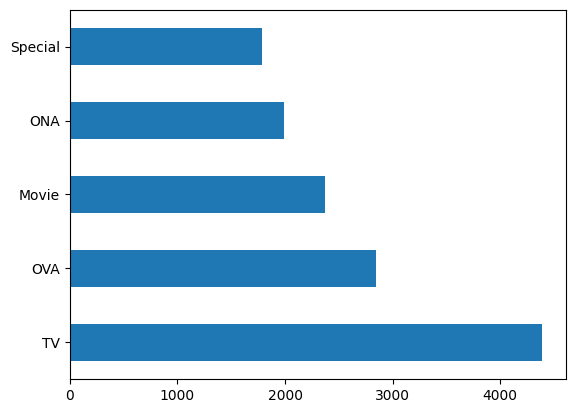

In [ ]:
anime_df.type.value_counts().plot(kind='barh')

In [ ]:
tvmv_ova_df = anime_df[anime_df.type.isin(['Movie', 'TV', 'OVA'])]
tvmv_ova_df.shape

(9606, 38)

<Axes: xlabel='score_count', ylabel='Density'>

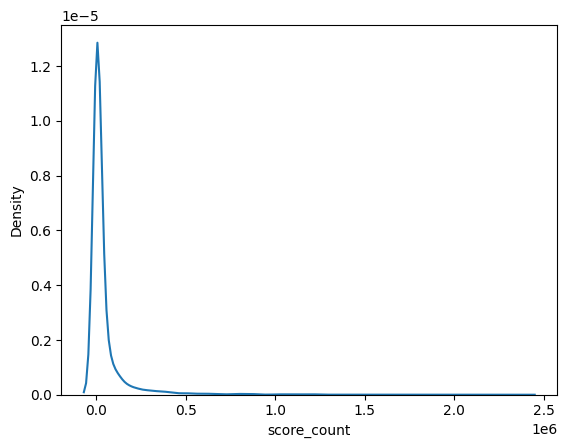

In [ ]:
sns.kdeplot(tvmv_ova_df.score_count)

In [ ]:
#Get only those in top 7500 and have number of people vote higher than 30%
tvmv_ova_df = tvmv_ova_df[~((tvmv_ova_df['popularity_rank']> 7500) &(tvmv_ova_df.score_count < tvmv_ova_df.score_count.quantile(0.3)))]
tvmv_ova_df.shape

(7334, 38)

In [ ]:
%time user_df = user_df[user_df.anime_id.isin(tvmv_ova_df.anime_id)]

df.info()

CPU times: user 947 ms, sys: 932 ms, total: 1.88 s
Wall time: 2.01 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964847 entries, 0 to 2964846
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   anime_id  int64  
 2   score     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 67.9+ MB


In [ ]:
#Each user can vote anime multiple times, only get the highest vote
%time user_df = user_df.groupby(['anime_id', 'user_id'])['score'].max()

CPU times: user 17 s, sys: 4.05 s, total: 21.1 s
Wall time: 21.4 s


In [ ]:
#Pivot the table
%time user_df = user_df.unstack()
user_df.info()

CPU times: user 10.8 s, sys: 10.4 s, total: 21.2 s
Wall time: 21.5 s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7062 entries, 1 to 51304
Columns: 84947 entries, doommantia to zzzzzzzzzzzenith
dtypes: float64(84947)
memory usage: 4.5 GB


In [ ]:
gc.collect()
%time user_df.isnull().mean().mean()

CPU times: user 1.31 s, sys: 1.08 s, total: 2.4 s
Wall time: 2.46 s


0.9834751978241337

In [ ]:
#Note that since user_df now only have user_id and anime_id
pivot_sparse_df = user_df.astype(pd.SparseDtype('int64', np.nan))

del user_df
gc.collect()

0

In [ ]:
pivot_sparse_df.index.name = None #Must remove the index name, or to_coo() method in the training will return error
pivot_sparse_df.head(40)


user_id,doommantia,doommark,doommsatic,doommustdie,doomnd,doomnezau,doomni,doomnick,doomnoises,doomofgloom2,...,zzzzplsdontlook,zzzzqt,zzzzzarah,zzzzzelda,zzzzzrmzzzzz,zzzzztttt,zzzzzz1232,zzzzzzero,zzzzzzzz,zzzzzzzzzzzenith
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,NaN,NaN,NaN,10.0,9.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
6,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,9.0,8.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,10.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tvmv_ova_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7334 entries, 0 to 11595
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anime_id             7334 non-null   int64  
 1   anime_url            7334 non-null   object 
 2   title                7334 non-null   object 
 3   synopsis             7332 non-null   object 
 4   main_pic             7334 non-null   object 
 5   type                 7334 non-null   object 
 6   source_type          7334 non-null   object 
 7   num_episodes         7094 non-null   float64
 8   status               7334 non-null   object 
 9   start_date           7214 non-null   object 
 10  end_date             7001 non-null   object 
 11  season               3653 non-null   object 
 12  studios              6301 non-null   object 
 13  genres               7334 non-null   object 
 14  score                5717 non-null   float64
 15  score_count          5717 non-null   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Since I use Colab, I want to export pickle to my Drive

KeyboardInterrupt: 

In [ ]:

pivot_sparse_df.to_pickle('/content/drive/MyDrive/AnimeRecommenderPickle/UserAnimeList_Pivot.pkl')
anime_df['genres'] = anime_df['genres']
anime_df['studios'] = anime_df['studios']
anime_smp_df = anime_df[['anime_id', 'anime_url', 'title', 'main_pic', 'type', 'source_type', 'num_episodes', 'score', 'score_rank', 'popularity_rank', 'studios', 'genres' ]]
anime_smp_df.to_parquet('/content/drive/MyDrive/AnimeRecommenderPickle/anime_db.parquet')
gc.collect()

0